<a href="https://colab.research.google.com/github/moajjem04/Pytorch_Practice/blob/main/Robot_Data_Processing_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Accessing Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd '/content/drive/MyDrive/robot'

/content/drive/.shortcut-targets-by-id/1xoj4fkjFWbgZZGpDNuTyZsH1-eOzncVi/robotic arm data - s


In [3]:
%pwd

'/content/drive/.shortcut-targets-by-id/1xoj4fkjFWbgZZGpDNuTyZsH1-eOzncVi/robotic arm data - s'

In [4]:
%ls

data_v2.pkl   Samling_for_Zhen_d_s2.csv         Samling_for_Zhen_lygf_e_s.csv
data_v3.pkl   Samling_for_Zhen_d_s.csv          Samling_for_Zhen_oyg_2e_s.csv
IMG_4598.MOV  Samling_for_Zhen_g_S.csv          Samling_for_Zhen_oyg_e_s1.csv
IMG_4599.MOV  Samling_for_Zhen_lg_e_s.csv       Samling_for_Zhen_w_s.csv
IMG_4600.MOV  Samling_for_Zhen_Lizhuoxun_S.csv  Samling_for_Zhen_x_s.csv
IMG_4601.MOV  Samling_for_Zhen_l_s.csv          Samling_for_Zhen_yg_e_s.csv
IMG_4602.MOV  Samling_for_Zhen_lyfg_2e_s.csv


# Loading the Data

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files
import os
import pickle

In [6]:
file_name = "data_v3.pkl"
open_file = open(file_name, "rb")
Data = pickle.load(open_file)
open_file.close()

In [7]:
Data.keys()

dict_keys(['name_class', 'train_sig', 'val_sig', 'train_class', 'val_class', 'time_dict'])

In [8]:
name_class  = Data['name_class']
train_sig   = Data['train_sig']
val_sig     = Data['val_sig']
train_class = Data['train_class']
val_class   = Data['val_class']

In [9]:
%reset_selective -f Data

In [10]:
try:
  Data.keys()
except:
  print('No Data')

No Data


In [11]:
print('The total data')
print('Training Data shape:',train_sig.shape)
print('Validation Data shape:',val_sig.shape)
print('Training Class shape:',train_class.shape)
print('Validation Class shape:',val_class.shape)
temp = val_sig.shape[0]/(train_sig.shape[0] + val_sig.shape[0])
print('Proportion of Validation Data:',round(temp*100,2),'%')

The total data
Training Data shape: (2515, 21, 5000, 1)
Validation Data shape: (585, 21, 5000, 1)
Training Class shape: (2515, 1)
Validation Class shape: (585, 1)
Proportion of Validation Data: 18.87 %


## Shuffling the Data

In [12]:
np.random.seed(42)

In [13]:
train_idx = np.arange(0,train_sig.shape[0])
val_idx = np.arange(0,val_sig.shape[0])

In [14]:
np.random.shuffle(train_idx)
np.random.shuffle(val_idx)

In [15]:
train_idx

array([ 617,  927,  942, ..., 1130, 1294,  860])

In [16]:
train_sig   = train_sig[train_idx,:,:,:]
train_class = train_class[train_idx,:]
val_sig     = val_sig[val_idx,:,:,:]
val_class   = val_class[val_idx,:]

In [17]:
val_class = val_class.reshape(val_class.shape[0])
print(val_class.shape)
train_class = train_class.reshape(train_class.shape[0])
print(train_class.shape)

(585,)
(2515,)


In [18]:
train_class[0]

3.0

# Defining the Neural Network Architecture

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torch.optim as optim
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv1d, MaxPool1d, Module, Softmax, BatchNorm1d, Dropout, MSELoss
from torch.optim import Adam, SGD

from tqdm import tqdm

In [20]:
class Net(nn.Module):
  def __init__(self,n_channels):
    super().__init__()

    self.cnn_layers = Sequential(
        # Defining a 1D convolution layer
        Conv1d(n_channels, 32, kernel_size=5, padding=1),
        BatchNorm1d(32),
        ReLU(inplace=True),
        MaxPool1d(kernel_size=2, stride=2),
        # Defining another 1D convolution layer
        Conv1d(32, 64, kernel_size=5, padding=1),
        BatchNorm1d(64),
        ReLU(inplace=True),
        MaxPool1d(kernel_size=2, stride=2),
        # Defining another 1D convolution layer
        Conv1d(64, 64, kernel_size=5, padding=1),
        BatchNorm1d(64),
        ReLU(inplace=True),
        MaxPool1d(kernel_size=2, stride=2),
    )
    # This code is used calculate the size of the flattened layer by having one
    #   pass forward
    x = torch.randn(21,5000).view(-1,21,5000)
    self._to_linear = None
    self.convs(x)

    self.flat = nn.Flatten()

    self.linear_layers = Sequential(
                Linear(self._to_linear, 13)
            )

  def convs(self, x):
    # max pooling over 2x2
    x = self.cnn_layers(x)
    #print(x[0].shape)

    if self._to_linear is None:
      self._to_linear = x[0].shape[0]*x[0].shape[1]
    return x

  def forward(self, x):
    x = self.convs(x)
    x = self.flat(x)
    x = self.linear_layers(x)
    return x

In [38]:
net = Net(21)
print(net)

Net(
  (cnn_layers): Sequential(
    (0): Conv1d(21, 32, kernel_size=(5,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=(1,))
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv1d(64, 64, kernel_size=(5,), stride=(1,), padding=(1,))
    (9): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear_layers): Sequential(
    (0): Linear(in_features=39872, out_features=13, bias=True)
  )
)


In [22]:
from torchsummary import summary
summary(net.cuda(), (21,5000))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 32, 4998]           3,392
       BatchNorm1d-2             [-1, 32, 4998]              64
              ReLU-3             [-1, 32, 4998]               0
         MaxPool1d-4             [-1, 32, 2499]               0
            Conv1d-5             [-1, 64, 2497]          10,304
       BatchNorm1d-6             [-1, 64, 2497]             128
              ReLU-7             [-1, 64, 2497]               0
         MaxPool1d-8             [-1, 64, 1248]               0
            Conv1d-9             [-1, 64, 1246]          20,544
      BatchNorm1d-10             [-1, 64, 1246]             128
             ReLU-11             [-1, 64, 1246]               0
        MaxPool1d-12              [-1, 64, 623]               0
          Flatten-13                [-1, 39872]               0
           Linear-14                   

In [23]:
torch.cuda.is_available()

True

In [39]:
optimizer = Adam(net.parameters(),lr = 1e-3)
criterion = CrossEntropyLoss()
#criterion = MSELoss()
if torch.cuda.is_available():
  net = net.cuda()
  criterion = criterion.cuda()

In [25]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore')
#a = enc.fit_transform(train_y)

In [26]:
# converting training images into torch format
train_x = train_sig.astype(float)
train_x = train_x.reshape(train_sig.shape[0], 21,5000)
train_x  = torch.from_numpy(train_x)

# converting the target into torch format
train_y = train_class.astype(int)
#train_y = enc.fit_transform(train_y)
train_y = torch.from_numpy(train_y)

# shape of training data
train_x.shape, train_y.shape

(torch.Size([2515, 21, 5000]), torch.Size([2515]))

In [27]:
type(train_x[0])

torch.Tensor

In [28]:
# converting training images into torch format
val_x = val_sig.astype(float)
val_x = val_sig.reshape(val_sig.shape[0], 21,5000)
val_x  = torch.from_numpy(val_x)

# converting the target into torch format
val_y = val_class.astype(int)
#val_y = 
val_y = torch.from_numpy(val_y)

# shape of training data
val_x.shape, val_y.shape

(torch.Size([585, 21, 5000]), torch.Size([585]))

In [98]:
def train(model,batch_size,epochs):
    
    for epoch in range(epochs):
      tr_loss = []
      val_loss = []
      for i in tqdm(range(0,len(train_y),batch_size)):
        batch_X = train_x[i:i+batch_size].float()
        batch_y = train_y[i:i+batch_size]

        if torch.cuda.is_available():
          batch_X = batch_X.cuda()
          batch_y = batch_y.cuda()

        model.zero_grad()
        output_train = model(batch_X)
        # print(output_train.shape)
        # print(output_train)
        # print(batch_y.shape)
        loss_train = criterion(output_train, batch_y)
        tr_loss.append(loss_train.item())

        # computing the updated weights of all the model parameters
        loss_train.backward()
        optimizer.step()
        #tr_loss = loss_train.item()
      train_losses.append(np.mean(tr_loss))
      with torch.no_grad():
        for j in tqdm(range(0,len(val_y),batch_size)):
          val_batch_X = val_x[j:j+batch_size].float()
          val_batch_y = val_y[j:j+batch_size]
          # print(val_batch_X.shape)
          # print(batch_X.shape)

          if torch.cuda.is_available():
            val_batch_X = val_batch_X.cuda()
            val_batch_y = val_batch_y.cuda()

          output_val = model(val_batch_X)
          loss_val = criterion(output_val, val_batch_y)
          val_loss.append(loss_val.item())   
        val_losses.append(np.mean(val_loss))      
      if (epoch+1)%10 == 0:
        # printing the validation loss
          print('Epoch : ',epoch+1, '\t', 'val loss :', np.mean(val_loss))  
          print('Epoch : ',epoch+1, '\t', 'train loss :', np.mean(tr_loss))     


In [99]:
# defining the number of epochs
n_epochs = 10
batch_size = 32
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []
# training the model
train(net,batch_size,n_epochs)

100%|██████████| 19/19 [00:00<00:00, 96.57it/s]

Epoch :  10 	 val loss : 14.648053796667801
Epoch :  10 	 train loss : 0.12625611989605653


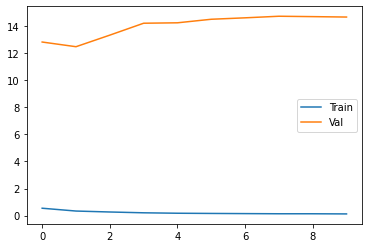

In [101]:
import matplotlib.pyplot as plt
plt.plot(train_losses,label = 'Train')
plt.plot(val_losses, label = 'Val')
plt.legend()

In [41]:
from sklearn.metrics import confusion_matrix

In [71]:
def get_pred(model,feature):
  with torch.no_grad():
    pred = model(feature.float().cuda())

  pred = pred.cpu()
  pred = np.array(pred)
  pred = np.argmax(pred,1)

  return pred 


In [73]:
train_pred = get_pred(net,train_x)
val_pred   = get_pred(net,val_x)

In [75]:
confusion_matrix(train_y, train_pred)

array([[134,   4,   0,   0,   0,   0,   0,   1,   0,   4,   0,   1,   0],
       [  0, 139,   3,   0,   0,   0,   0,   0,   0,   1,   0,   1,   0],
       [  0,   0, 178,   1,   0,   0,   0,   0,   1,   2,   0,   4,   0],
       [  0,   0,   0, 188,   4,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   1,   0,   2, 176,   0,   1,   8,   0,   0,   0,   0,   4],
       [  0,   0,   0,   0,   0,  60,  94,   4,  10,  29,   0,   0,   0],
       [  0,   0,   0,   0,   0,  10, 147,   3,  10,  27,   0,   0,   0],
       [  0,   4,   0,   0,   0,   1,  29, 130,  10,  23,   0,   0,   0],
       [  3,   3,   1,   4,   0,   0,  19,   2,  68,  96,   0,   0,   1],
       [  2,   0,   2,   1,   0,   0,  19,   2,  31, 139,   0,   0,   1],
       [  0,   2,   3,   0,   0,   0,   0,   0,   0,   0, 217,   1,   1],
       [  4,   0,   0,   3,   0,   0,   0,   0,   1,   0,   0, 216,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0,   0,   1,   0,   2, 220]])

In [76]:
confusion_matrix(val_y, val_pred)

array([[29,  0,  0,  4,  0,  0,  0,  0,  0,  1,  0, 11,  0],
       [14, 17,  2,  2,  0,  0,  0,  0,  3,  3,  2,  2,  0],
       [ 0,  0, 41,  0,  0,  0,  0,  0,  0,  0,  0,  4,  0],
       [ 0,  0,  0, 37,  0,  0,  0,  0,  0,  1,  0,  7,  0],
       [ 0,  0,  0, 37,  0,  0,  0,  0,  0,  1,  0,  7,  0],
       [ 0,  2,  0,  0,  0, 17, 16,  1,  1,  8,  0,  0,  0],
       [ 0,  2,  0,  0,  0, 17, 16,  1,  1,  8,  0,  0,  0],
       [ 0,  2,  0,  0,  0, 17, 16,  1,  1,  8,  0,  0,  0],
       [ 0,  2,  0,  0,  0, 17, 16,  1,  1,  8,  0,  0,  0],
       [ 0,  2,  0,  0,  0, 17, 16,  1,  1,  8,  0,  0,  0],
       [ 0,  0, 18,  1,  0,  0,  0,  0,  0,  0, 26,  0,  0],
       [ 0,  0, 14,  1,  0,  0,  0,  0,  0,  0, 24,  6,  0],
       [ 0,  0, 12,  1,  0,  0,  0,  0,  0,  0, 16,  0, 16]])

In [79]:
from sklearn.metrics import classification_report

In [84]:
print(classification_report(train_y, train_pred))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       144
           1       0.91      0.97      0.94       144
           2       0.95      0.96      0.95       186
           3       0.94      0.98      0.96       192
           4       0.98      0.92      0.95       192
           5       0.83      0.30      0.45       197
           6       0.48      0.75      0.58       197
           7       0.87      0.66      0.75       197
           8       0.52      0.35      0.41       197
           9       0.43      0.71      0.54       197
          10       1.00      0.97      0.98       224
          11       0.96      0.96      0.96       224
          12       0.97      0.98      0.98       224

    accuracy                           0.80      2515
   macro avg       0.83      0.80      0.80      2515
weighted avg       0.83      0.80      0.80      2515



In [85]:
print(classification_report(val_y, val_pred))

              precision    recall  f1-score   support

           0       0.67      0.64      0.66        45
           1       0.63      0.38      0.47        45
           2       0.47      0.91      0.62        45
           3       0.45      0.82      0.58        45
           4       0.00      0.00      0.00        45
           5       0.20      0.38      0.26        45
           6       0.20      0.36      0.26        45
           7       0.20      0.02      0.04        45
           8       0.12      0.02      0.04        45
           9       0.17      0.18      0.18        45
          10       0.38      0.58      0.46        45
          11       0.16      0.13      0.15        45
          12       1.00      0.36      0.52        45

    accuracy                           0.37       585
   macro avg       0.36      0.37      0.33       585
weighted avg       0.36      0.37      0.33       585



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
